# BERT For Sentiment Analysis

Fork with test accuracy at 92%

### TODO (04/19)
* ~plot training and validation accuracy~
* compare accuracy to SOTA

### Current Work (03/30)
* ~Load in BERT base model from Transformers~
* ~Build classification head as modeled in Transformers~
* ~Load in our datasets and tokenize~
* Fine-tune classification head on our data
* ~Evaluate performance on test dataset~
* Strategies to prevent overfitting on train dataset

### Data
* [Archeage - Sentiment Analysis Datasets](https://github.com/hadis-1/Sentiment-Analysis-Datasets/blob/main/archeage.csv)
* [Ntua - Sentiment Analysis Datasets](https://github.com/hadis-1/Sentiment-Analysis-Datasets/blob/main/ntua.csv)
* [HCR - Sentiment Analysis Datasets](https://github.com/hadis-1/Sentiment-Analysis-Datasets/blob/main/hcr.csv)


#### Sources

* [HuggingFace Transformers models for PyTorch - BERT](https://github.com/huggingface/transformers/blob/94ae1ba5b55e79ba766582de8a199d8ccf24a021/src/transformers/models/bert/modeling_bert.py#L957)
* [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/pdf/1810.04805)
* [Word Representations: A Simple and General Method for Semi-Supervised Learning](https://www.researchgate.net/publication/220873681_Word_Representations_A_Simple_and_General_Method_for_Semi-Supervised_Learning)
* [HuggingFace documentation for Fine Tuning Transformer for MultiLabel Text Classification](https://colab.research.google.com/github/abhimishra91/transformers-tutorials/blob/master/transformers_multi_label_classification.ipynb#scrollTo=mZ7lTlkyaG7u)

In [1]:
# packages
import csv
import math
import torch
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from transformers import BertTokenizer
from transformers.models.bert import BertModel
from transformers.models.bert.configuration_bert import BertConfig

In [2]:
# constants
DEBUG = True
cfg = BertConfig()
BATCH_SIZE = 16
NUM_EPOCHS = 4

if not torch.cuda.is_available():
    print('GPU not available, running script on CPU..')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer):
        self.df = df
        self.data = df.review
        #self.labels = df.sentiment.tolist()
        #print(self.df['sentiment'].value_counts())
        self.tokenizer = tokenizer
        self.max_length = 512#cfg.max_length
        self.classes = [0, 1]  # negative, positive

        #self.inputs = self.tokenize(self.data)
    
    def get_num_classes(self):
        return len(self.classes)

    def __len__(self):
        return len(self.df)

    #def __getitem__(self, idx):
    #    #print(f"idx {idx}, label {self.df['sentiment'].iloc[idx]}, target {self.target_transform(idx)}")
    #    return self.tokenize(idx)

    def __getitem__(self, idx):
        #data = str(self.data[idx])
        #data = " ".join(data.split())
        #data = [" ".join(str(data).split()) for text in data.tolist()]
        text = str(self.data.iloc[idx])
        text = " ".join(text.split())  # clean whitespace
        
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            #pad_to_max_length=True,
            return_token_type_ids=True
            #return_tensors='pt',
        )

        label_str = self.df['sentiment'].iloc[idx]
        label = 1 if label_str == 'positive' else 0

        return {
            'ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
            'token_type_ids': torch.tensor(inputs['token_type_ids'], dtype=torch.long),
            #'targets': torch.tensor(self.target_transform(idx), dtype=torch.long)
            'targets': torch.tensor(label, dtype=torch.long)
        }  

    def target_transform(self, idx):
        if self.labels[idx] == 'positive':
            return 1
        elif self.labels[idx] == 'negative':
            return 0
        else:
            print('[ERROR]: label not accepted:', self.labels[idx], 'must be positive or negative')

In [4]:
# load and split data functions
def load_data_from_file(filepath, imdb=False):
    print('...loading dataset from file')
    
    df = pd.read_csv(filepath)

    if imdb:
        return df
    df['sentiment'] = df[df.columns[0]].values.tolist()
    new_df = df[['review', 'sentiment']].copy()

    return new_df

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews


In [6]:
archeage_df = load_data_from_file('/kaggle/input/archeage/archeage.csv')
print(archeage_df.head())
ntua_df = load_data_from_file('/kaggle/input/ntua-dataset/ntua.csv')
print(ntua_df.head())
hcr_df = load_data_from_file('/kaggle/input/hcr-dataset/hcr.csv')
print(hcr_df.head())
imdb_df = load_data_from_file('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv', True)
print(imdb_df.head())
all_data = pd.concat([archeage_df, ntua_df, hcr_df, imdb_df], ignore_index=True)

train_size = 0.7
val_size = 0.2

train_dataset = all_data.sample(frac=train_size,random_state=200)
remaining = all_data.drop(train_dataset.index).reset_index(drop=True)
val_dataset = remaining.sample(frac=train_size+val_size,random_state=200)
test_dataset = remaining.drop(val_dataset.index).reset_index(drop=True)

train_dataset = train_dataset.reset_index(drop=True)
val_dataset = val_dataset.reset_index(drop=True)
test_dataset = test_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(all_data.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("VALIDATION Dataset: {}".format(val_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = SentimentDataset(train_dataset, tokenizer)
val_dataset = SentimentDataset(val_dataset, tokenizer)
test_dataset = SentimentDataset(test_dataset, tokenizer)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

...loading dataset from file
                                              review sentiment
0  @archeage i appreciate the "some few of you" :...  positive
1                               @archeage i love you  positive
2  @archeage been playing for the pass 3 days and...  positive
3  yay #archeage is working for me now... dunno a...  positive
4  played archeage (pc); guild wars 2 (pc) and 1 ...  positive
...loading dataset from file
                                              review sentiment
0  @ddlovato hey, I just wanted to no when your d...  positive
1  Great Morning USA! @JoeJonasLoverxo @Courtney7...  positive
2  RT @AtlanticGolf Post a comment on our fan pag...  positive
3  Beautifull news - "endless music" of Michael J...  positive
4            Hungry? Maybe? Reading harry potter. :)  positive
...loading dataset from file
                                              review sentiment
0                       Watching history unfold #HCR  positive
1  Every single person I encoun

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
class BERTForSentimentAnalysis(BertModel):
    """
    from Bert For Sequence Classification
    """
    def __init__(self, config):
        super().__init__(config=config)
        self.num_labels = 2
        self.config = config

        self.bert = BertModel(config)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(config.hidden_size, self.num_labels)

        #self.post_init()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None,):        
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=False
        )
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        return logits

In [8]:
print('...creating BERT model')
model = BERTForSentimentAnalysis(cfg).from_pretrained('bert-base-uncased')
model.to(DEVICE)
#from torchsummary import summary
#summary(model, ())

...creating BERT model


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BERTForSentimentAnalysis were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight'

BERTForSentimentAnalysis(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1

In [9]:
def loss_fn(outputs, targets):
    return torch.nn.CrossEntropyLoss()(outputs, targets)
#optimizer = torch.optim.Adam(params=model.parameters(), lr=2e-5)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-05, betas=(0.9, 0.999), eps=1e-08)

In [10]:
def compute_accuracy(outputs, targets):
    predictions = torch.argmax(outputs, 1)
    num_predictions = len(predictions)

    predictions = predictions.cpu()
    targets = targets.cpu()
    num_incorrect = 0
    for i in range(len(predictions)):
        if not predictions[i] == targets[i]:
            num_incorrect = num_incorrect + 1
    accuracy = (num_predictions-num_incorrect)/num_predictions

    return accuracy

In [11]:
def train(model, dataloader, device, epoch, num_epochs, total_steps):
    running_loss = 0.0
    running_acc = 0.0
    model.train()

    for i,data in enumerate(dataloader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        accuracy = compute_accuracy(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += accuracy

        if (i+1) % 50 == 0:
            print(
                f'TRAINING --> Epoch: {epoch+1}/{num_epochs}, ' +
                f'Step: {i+1}/{total_steps}, ' +
                f'Loss: {running_loss / (i+1)}, '
                f'Accuracy: {running_acc / (i+1)}'
            )
    
    running_loss = running_loss / total_steps
    running_acc = running_acc / total_steps

    return running_loss, running_acc

In [12]:
def validate(model, dataloader, device, epoch, num_epochs, total_steps):
    running_loss = 0.0
    running_acc = 0.0
    model.eval()

    with torch.no_grad():
        for i,data in enumerate(dataloader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)

            #print('model input')
            #print(ids.shape, mask.shape, token_type_ids.shape)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            accuracy = compute_accuracy(outputs, targets)
    
            running_loss += loss.item()
            running_acc += accuracy
    
            if (i+1) % 50 == 0:
                print(
                    f'VALIDATION --> Epoch: {epoch+1}/{num_epochs}, ' +
                    f'Step: {i+1}/{total_steps}, ' +
                    f'Loss: {running_loss / (i+1)}, '
                    f'Accuracy: {running_acc / (i+1)}'
                )
    running_loss = running_loss / total_steps
    running_acc = running_acc / total_steps

    return running_loss, running_acc

In [13]:
def save_best_model(
    model: torch.nn.Module,
    model_save_path,
    val_loss: float,
    val_losses: list,
    epoch: int,
    keep_models: bool = False
):
    """Save the model if it is the first epoch. Subsequently, save the model
    only if a lower validation loss is achieved whilst training.

    :param model: The model to save.
    :type model: torch.nn.Module
    :param model_save_path: The location to save the model to.
    :type model_save_path: Path
    :param val_loss: The current epoch's validation loss.
    :type val_loss: float
    :param val_losses: The history of all other validation losses.
    :type val_losses: list
    :param epoch: The current epoch number.
    :type epoch: int
    :param keep_models: Should all models be saved, defaults to False
    :type keep_models: bool, optional
    """
    # Should we keep all models or just one
    if keep_models:
        model_save_path = model_save_path / f'model_{epoch+1}_{val_loss}.pt'
    else:
        model_save_path = model_save_path / f'model_state_dict.pt'
    # Save the first model
    if len(val_losses) == 0:
        torch.save(
            model.state_dict(),
            model_save_path
        )
        print(
            'SAVING --> First epoch: \n' +
            f'Val Loss: {val_loss}\n' +
            f'Saving new model to:\n{model_save_path}'
        )
    elif val_loss < min(val_losses):
        # If our new validation loss is less than the previous best save the
        # model
        print(
            'SAVING --> Found model with better validation loss: \n' +
            f'New Best Val Loss: {val_loss}\n' +
            f'Old Best Val Loss: {min(val_losses)}\n'
            f'Saving new model to:\n{model_save_path}'
        )
        torch.save(
            model.state_dict(),
            model_save_path
        )

In [14]:
def plot_epoch_metrics(x, y, data_names, title_prefix, yaxis_label):
    """Plot metrics with the number of epochs on the x axis and the metric of
    interest on the y axis. Note that this function differs based on the input.

    :param x: The values to use on the x-axis.
    :type x: list
    :param y: A list of lists containing len(x) data points to plot. The inner
        lists are the different series to plot.
    :type y: list
    :param data_names: Names of the series to use in the legend.
    :type data_names: str
    :param title_prefix: A prefix to add before everything else in the title.
    :type title_prefix: str
    :param yaxis_label: The label for the y axis.
    :type yaxis_label: str
    """
    # Plot multiple series of data
    for i in y:
        plt.plot(x, i)
    # Set the title
    plt.title(title_prefix + ' ' + ' vs. '.join(data_names) + ' ' + yaxis_label)
    # Set the y axis label
    plt.ylabel(yaxis_label)
    # Enable the legend with the appropriate names
    plt.legend(data_names)

In [15]:
def train_loop(model, train_dataloader, val_dataloader, device, num_epochs, model_save_path=Path('./models')):
    print(f'Models will be saved to: {model_save_path}')
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    if not model_save_path.exists():
        model_save_path.mkdir(exist_ok=True, parents=True)

    train_total_steps = len(train_dataloader)
    val_total_steps = len(val_dataloader)

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model, train_dataloader, device, epoch, num_epochs, train_total_steps)
        print(
            f'TRAINING --> Epoch {epoch+1}/{NUM_EPOCHS} DONE, ' +
            f'Avg Loss: {train_loss}, Avg Accuracy: {train_accuracy}'
        )

        val_loss, val_accuracy = validate(model, val_dataloader, device, epoch, num_epochs, val_total_steps)
        print(
            f'VALIDATION --> Epoch {epoch+1}/{NUM_EPOCHS} DONE, ' +
            f'Avg Loss: {val_loss}, Avg Accuracy: {val_accuracy}'
        )

        save_best_model(model, model_save_path, val_loss, val_losses, epoch)
        
        train_losses.append(train_loss)
        train_accs.append(train_accuracy)
        val_losses.append(val_loss)
        val_accs.append(val_accuracy)
    return (train_losses, train_accs), (val_losses, val_accs)

In [16]:
print('training..')
(train_losses, train_accs), (val_losses, val_accs) = train_loop(model, train_dataloader, val_dataloader, DEVICE, NUM_EPOCHS)
print(f'Best Validation Loss: {min(val_losses)} after epoch {np.argmin(val_losses) + 1}')
print(f'Best Validation Acc: {max(val_accs)} after epoch {np.argmax(val_accs) + 1}')

training..
Models will be saved to: models
TRAINING --> Epoch: 1/4, Step: 50/2359, Loss: 0.6768017554283142, Accuracy: 0.575
TRAINING --> Epoch: 1/4, Step: 100/2359, Loss: 0.5834548401832581, Accuracy: 0.67875
TRAINING --> Epoch: 1/4, Step: 150/2359, Loss: 0.49108465457955996, Accuracy: 0.74875
TRAINING --> Epoch: 1/4, Step: 200/2359, Loss: 0.45258478473871944, Accuracy: 0.7775
TRAINING --> Epoch: 1/4, Step: 250/2359, Loss: 0.416038671195507, Accuracy: 0.80025
TRAINING --> Epoch: 1/4, Step: 300/2359, Loss: 0.39597084154685336, Accuracy: 0.8145833333333333
TRAINING --> Epoch: 1/4, Step: 350/2359, Loss: 0.38247609864388193, Accuracy: 0.8248214285714286
TRAINING --> Epoch: 1/4, Step: 400/2359, Loss: 0.36941313633695244, Accuracy: 0.8325
TRAINING --> Epoch: 1/4, Step: 450/2359, Loss: 0.3601060991237561, Accuracy: 0.8380555555555556
TRAINING --> Epoch: 1/4, Step: 500/2359, Loss: 0.35211446235328914, Accuracy: 0.842625
TRAINING --> Epoch: 1/4, Step: 550/2359, Loss: 0.34454495819454845, Accur

In [17]:
def evaluate(model, dataloader, device, total_steps):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0

    with torch.no_grad():
        for i,data in enumerate(dataloader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
    
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            accuracy = compute_accuracy(outputs, targets)
    
            running_loss += loss.item()
            running_acc += accuracy
    
            if (i+1) % 256 == 0:
                print(
                    f'TEST' +
                    f'Step: {i+1}/{total_steps}, ' +
                    f'Loss: {running_loss / (i+1)}, '
                    f'Accuracy: {running_acc / (i+1)}'
                )
    running_loss = running_loss / total_steps
    running_acc = running_acc / total_steps

    return running_loss, running_acc

In [18]:
test_loss, test_accuracy = evaluate(model, test_dataloader, DEVICE, len(test_dataloader))
print(
    f'TEST --> DONE, ' +
    f'Avg Loss: {test_loss}, Avg Accuracy: {test_accuracy}'
)

TEST --> DONE, Avg Loss: 0.20357077622640074, Avg Accuracy: 0.9301470588235294


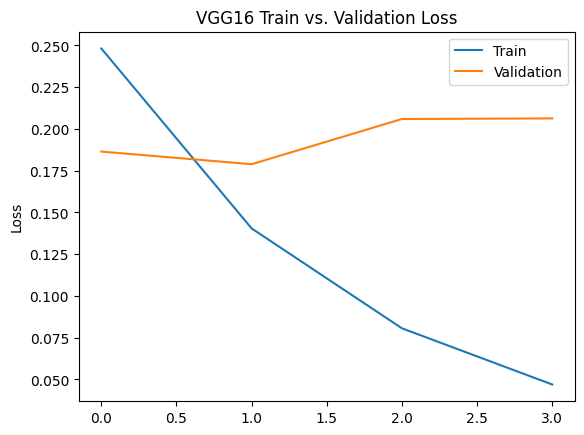

In [19]:
plot_epoch_metrics(
    np.arange(NUM_EPOCHS),
    [train_losses, val_losses],
    ['Train', 'Validation'],
    'VGG16',
    'Loss'
)

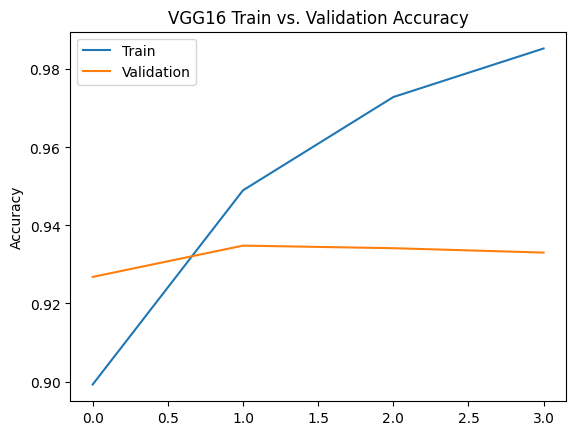

In [20]:
plot_epoch_metrics(
    np.arange(NUM_EPOCHS),
    [train_accs, val_accs],
    ['Train', 'Validation'],
    'VGG16',
    'Accuracy'
)

In [21]:
#!pip install onnx
#!pip install onnxscript

In [22]:
"""
# Model class must be defined somewhere
for PATH in os.listdir('/kaggle/working'):
    full_path = PATH.split('.')
    arch = PATH.split('_')[0]
    model_id = ''.join(full_path[0:len(full_path)-1])
    if full_path[-1] == 'pth':
        print('deploying to onnx:', model_id)
        if arch == 'mobilenetv2':
            model = MobileNetFaceDetector()
        elif arch == 'yolo':
            model = YOLOFaceDetector()
        else:
            print('ERROR: model architecture not supported:', arch)
        model.load_state_dict(torch.load(PATH))
        model.to(device)
        model.eval()
        dummy_input = torch.randn(1, 3, 224, 224).to(device)  # Adjust shape based on your model's input size
        
        # Export the model to ONNX
        torch.onnx.export(
            model,  # The loaded PyTorch model
            dummy_input,  # Example input tensor
            f"{model_id}.onnx",  # Output ONNX file name
            export_params=True,  # Store trained parameters
            opset_version=13,  # ONNX version (adjust as needed)
            do_constant_folding=True,  # Optimize by folding constants
            input_names=["input"],  # Naming input tensor
            output_names=["output"],  # Naming output tensor
            dynamic_axes=None 
        )
        
        print("...Model successfully exported to ONNX!")
"""

'\n# Model class must be defined somewhere\nfor PATH in os.listdir(\'/kaggle/working\'):\n    full_path = PATH.split(\'.\')\n    arch = PATH.split(\'_\')[0]\n    model_id = \'\'.join(full_path[0:len(full_path)-1])\n    if full_path[-1] == \'pth\':\n        print(\'deploying to onnx:\', model_id)\n        if arch == \'mobilenetv2\':\n            model = MobileNetFaceDetector()\n        elif arch == \'yolo\':\n            model = YOLOFaceDetector()\n        else:\n            print(\'ERROR: model architecture not supported:\', arch)\n        model.load_state_dict(torch.load(PATH))\n        model.to(device)\n        model.eval()\n        dummy_input = torch.randn(1, 3, 224, 224).to(device)  # Adjust shape based on your model\'s input size\n        \n        # Export the model to ONNX\n        torch.onnx.export(\n            model,  # The loaded PyTorch model\n            dummy_input,  # Example input tensor\n            f"{model_id}.onnx",  # Output ONNX file name\n            export_para